# Asian option pricing using quasi-Monte Carlo approach
#### Hamed Helali

## Introduction
In this project, I am using Monte Carlo simulation approach to price a hypothetical asian option in a hypothetical environment. My objective is to compare performance of quasi-Monte Carlo methods (using Sobol and Halton sequences) with ordinary Monte Carlo simulation.
### Performance Comparison
Performance comparison is done in terms of the largest sample size, by which a method can reach (required) small enough precision (which is proportionate to confidence interval length of the estimation). We will assume that required threshold for confidence interval length is 0.5 dollar.

## Quasi-Monte Carlo Method
Quasi-Monte Carlo method for simulation is used in order to get required precision with smaller sample sizes. This approach uses *low-descrepancy sequences* for simulation instead of *psuedorandom* numbers in the ordinary Monte Carlo methods.

## Asian option
Asian options is a path-dependant option in which the payoff depends on average price of an underlying asset during the option period. The type option we price here is *average-price asian call option* which has the payoff:

$$
payoff = max\{average(price) - X\}
$$
Where is X is the exercise price of the option.
### Underlying asset process
Price of the underlying asset is assumed to follow the stochastic process of geometric brownian motion which means:

$$
S(t + \Delta t) = S(t)e^{(r - \frac{\sigma ^2}{2})\Delta t + \sigma \epsilon \sqrt{\Delta t}}
$$ 

In [ ]:
!pip install chaospy

In [1]:
import numpy as np
import chaospy as ch
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

## Defining some helper functions

In [2]:
def payoff_calc(price_array, X):
    """
    This function calculates future payoff of the asian option based on arithmetic average of the price path
    
    INPUT:
        price_array (numpy.ndarray): A one-dimensional array of stock final prices
        X (float): Exercise price of the option
    
    OUTPUT:
        (numpy.ndarray): A one dimensional array of payoffs for different prices
    """
    
    payoff = np.maximum(0, np.mean(price_array) - X)
    return payoff

In [3]:
def pv_calc(FV, r, T):
    """
    Calculates present value of an amount of money in future.
    
    INPUT:
        FV (float): Future value of money
        r (float): Risk neutral interest rate
        T (float): Period of time
    
    OUTPUT:
        (float): Present value of FV
    """
    
    return FV * np.exp(-r * T)

In [4]:
def CI_calc(s_array):
    """
    Calculates 95% confidence interval for the estimation of expected value of a random variable, given a sample.
    
    INPUT:
        s_array (Numpy.ndarray): A one-dimensional array of the sample
    
    OUTPUT:
        (Numpy.ndarray): with shape==(1,2) which has lower and upper bound of the confidence interval
    """
    
    X_bar = np.mean(s_array)
    Upper_b = X_bar + (np.sqrt(np.var(s_array)) * stats.norm.ppf(0.975)) / np.sqrt(len(s_array))
    Lower_b = X_bar - (np.sqrt(np.var(s_array)) * stats.norm.ppf(0.975)) / np.sqrt(len(s_array))
    return np.array([Lower_b, Upper_b])

In [17]:
def sobol_generator(m, n):
    """
    Generates m samples (each for one path) each having n numbers in Sobol sequence.
    
    INPUT:
        m (int): number of samples
        n (int): number of Sobol sequence numbers in each sample
        
    OUTPUT:
        (numpy.ndarray): A two-dimensional array of Sobol sequence numbers for conducting QMC simulation
    """
    sob_array = np.empty((0, n))
    for i in range(m // 39 + 1):
        sob = ch.create_sobol_samples(n, 39, i)
        sob_array = np.append(sob_array, sob, axis=0)
    return sob_array

In [6]:
def halton_generator(m, n):
    """
    Generates m samples each having n numbers in Halton sequence.
    
    INPUT:
        m (int): The order of Halton sequence. Defines the number of samples
        n (int): Dimension of each sequence.Defines the number of Halton sequence numbers in each sample.
        
    OUTPUT:
        (numpy.ndarray): A two-dimensional array of Sobol sequence numbers for conducting QMC simulation
    """
    hal_seq = ch.create_halton_samples(m, n)
    return hal_seq

In [8]:
def sobol_seq_sim(no_of_paths, n_steps, S_0, T, r, sigma, x_price):
    """
    Conducts QMC simulation using Sobol sequence.
    
    INPUT:
        no_of_paths (int): Number of samples in simulation
        n_steps (int): Number of price step we aim to simulate in each path
        S_0 (float): Underlying asset price at time zero
        T (float): Time period of option contract
        r (float): Risk-netural interest rate
        sigma (float): Volatility in the environment
        x_price (float): Exercise price of the option
        
    OUTPUT:
        (Numpy.ndarray): A one-dimensional array of present value of simulated payoffs
    """
    dt = T / n_steps
    present_payoffs = np.zeros(no_of_paths)
    epsilon_s = stats.norm.ppf(sobol_generator(no_of_paths, n_steps))
    
    for k in range(no_of_paths):
        price_steps = np.zeros(n_steps)
        price_steps[0] = S_0
        for i in range(1, n_steps):
            price_steps[i] = price_steps[i-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * epsilon_s[k, i] * np.sqrt(dt))
        present_payoffs[k] = pv_calc(payoff_calc(price_steps, x_price), r, T)
    return present_payoffs

In [9]:
def halton_seq_sim(no_of_paths, n_steps, S_0, T, r, sigma, x_price):
    """
    Conducts QMC simulation using Halton sequence.
    
    INPUT:
        no_of_paths (int): Number of samples in simulation
        n_steps (int): Number of price step we aim to simulate in each path
        S_0 (float): Underlying asset price at time zero
        T (float): Time period of option contract
        r (float): Risk-netural interest rate
        sigma (float): Volatility in the environment
        x_price (float): Exercise price of the option
        
    OUTPUT:
        (Numpy.ndarray): A one-dimensional array of present value of simulated payoffs
    """
    dt = T / n_steps
    present_payoffs = np.zeros(no_of_paths)
    epsilon_h = stats.norm.ppf(halton_generator(no_of_paths, n_steps))
    
    for k in range(no_of_paths):
        price_steps = np.zeros(n_steps)
        price_steps[0] = S_0
        for i in range(1, n_steps):
            price_steps[i] = price_steps[i-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * epsilon_h[i, k] * np.sqrt(dt))
        present_payoffs[k] = pv_calc(payoff_calc(price_steps, x_price), r, T)
    return(present_payoffs)

In [10]:
def ordinary_mc_sim(no_of_paths, n_steps, S_0, T, r, sigma, x_price):
    """
    Conducts MC simulation,
    
    INPUT:
        no_of_paths (int): Number of samples in simulation
        n_steps (int): Number of price step we aim to simulate in each path
        S_0 (float): Underlying asset price at time zero
        T (float): Time period of option contract
        r (float): Risk-netural interest rate
        sigma (float): Volatility in the environment
        x_price (float): Exercise price of the option
        
    OUTPUT:
        (Numpy.ndarray): A one-dimensional array of present value of simulated payoffs
    """
    dt = T / n_steps
    present_payoffs = np.zeros(no_of_paths)
    epsilon = np.random.normal(0, 1, (no_of_paths, n_steps))
    
    for k in range(no_of_paths):
        price_steps = np.zeros(n_steps)
        price_steps[0] = S_0
        for i in range(1, n_steps):
            price_steps[i] = price_steps[i-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * epsilon[k, i] * np.sqrt(dt))
        present_payoffs[k] = pv_calc(payoff_calc(price_steps, x_price), r, T)
    return(present_payoffs)

In [26]:
def sim_iterator(max_sample, n_steps, S_0, T, r, sigma, x_price, *,method):
    """
    Iterates simulation with different sample sizes (form 10 to a maximum size with steps of 10)
    and records estimated price as well as confidence interval of the estimation
    
    INPUT:
        max_sample (int): Maximum sample size for the iteration of simulations
        n_steps (int): Number of price step we aim to simulate in each path
        S_0 (float): Underlying asset price at time zero
        T (float): Time period of option contract
        r (float): Risk-netural interest rate
        sigma (float): Volatility in the environment
        x_price (float): Exercise price of the option
        method (string): 'sobol', 'halton' or 'ordinary'
    
    OUTPUT:
        (numpy.ndarray): confidence intervals of the simulations
        (numpy.ndarray): price estimations of the simulations
    """
    
    assert(method in ['sobol', 'halton', 'ordinary'])
    
    mean_pv_payoffs = np.zeros(int(np.ceil(max_sample / 10)))
    confidence_intervals = np.array([None, None])
    
    if method == 'sobol':
        for n_sample in range(10, max_sample + 1, 10):
            present_payoffs = sobol_seq_sim(n_sample, n_steps, S_0, T, r, sigma, x_price)
            mean_pv_payoffs[int(n_sample/10 - 1)] = np.mean(present_payoffs)
            confidence_intervals = np.row_stack((confidence_intervals, CI_calc(present_payoffs)))
    
    elif method == 'halton':
        for n_sample in range(10, max_sample + 1, 10):
            present_payoffs = halton_seq_sim(n_sample, n_steps, S_0, T, r, sigma, x_price)
            mean_pv_payoffs[int(n_sample/10 - 1)] = np.mean(present_payoffs)
            confidence_intervals = np.row_stack((confidence_intervals, CI_calc(present_payoffs)))
    
    elif method == 'ordinary':
        for n_sample in range(10, max_sample + 1, 10):
            present_payoffs = ordinary_mc_sim(n_sample, n_steps, S_0, T, r, sigma, x_price)
            mean_pv_payoffs[int(n_sample/10 - 1)] = np.mean(present_payoffs)
            confidence_intervals = np.row_stack((confidence_intervals, CI_calc(present_payoffs)))

    
    return confidence_intervals, mean_pv_payoffs

In [12]:
def CI_length_calc(CI):
    """
    Calculates length of a confidence interval.
    
    INPUT:
        CI (numpy.ndarray): Confidence intervals
    
    OUTPUT:
        (numpy.ndarray): lengths of the confidence intervals
    """
    
    return CI[1:, 1] - CI[1:, 0]

In [40]:
def threshold_finder(CI, tol):
    """
    In an array of confidence intervals in the order of descending lengths,
    returns the index of fist interval shorter than a threshold.
    
    INPUT:
        CI (numpy.ndarray): Confidence intervals
        tol (float): length threshold
    
    OUTPUT:
        (int): the index of fist interval shorter than 'tol'.
    """
    
    CI_length = CI_length_calc(CI)
    for i, length in enumerate(CI_length):
        if length <= tol:
            return i
    else:
        return None

## Conducting the simulations

In [33]:
r = 0.1
sigma = 0.2
T = 2
n_steps = 20
dt = T / n_steps
S_0 = 50
x_price = 40

max_sample = 7000


sobol_CIs, sobol_price_esitmates = sim_iterator(max_sample, n_steps, S_0, T, r, sigma, x_price, method='sobol')
halton_CIs, halton_price_esitmates = sim_iterator(max_sample, n_steps, S_0, T, r, sigma, x_price, method='halton')
ordinaryMC_CIs, ordinaryMC_price_esitmates = sim_iterator(max_sample, n_steps, S_0, T, r, sigma, x_price, method='ordinary')

In [44]:
print("Price estimated at largest sample size with Sobol sequence:", str(sobol_price_esitmates[-1]))
print("CI length at largest sample size with Sobol sequence:", str(sobol_CIs[-1,1] - sobol_CIs[-1,0]))

print("Price estimated at largest sample size with Halton sequence:", str(halton_price_esitmates[-1]))
print("CI length at largest sample size with Halton sequence:", str(halton_CIs[-1,1] - halton_CIs[-1,0]))

print("Price estimated at largest sample size with ordinary MC:", str(ordinaryMC_price_esitmates[-1]))
print("CI length at largest sample size with ordinary MC:", str(ordinaryMC_CIs[-1,1] - ordinaryMC_CIs[-1,0]))

Price estimated at largest sample size with Sobol sequence: 11.715011344960544
CI length at largest sample size with Sobol sequence: 0.17423024315435853
Price estimated at largest sample size with Halton sequence: 12.280725716144751
CI length at largest sample size with Halton sequence: 0.3330768226385423
Price estimated at largest sample size with ordinary MC: 12.388931350290722
CI length at largest sample size with ordinary MC: 0.33597514567397013


## Ploting the results

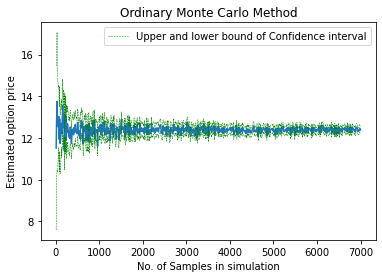

In [34]:
#Ploting ordinary Monte Carlo method
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, ordinaryMC_price_esitmates)
plt.plot(x_axis1, ordinaryMC_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, ordinaryMC_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()

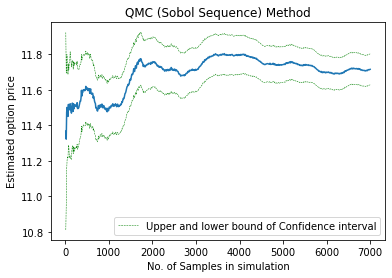

In [35]:
#Ploting quasi-Monte Carlo method using Sobol sequence

plt.plot(x_axis1, sobol_price_esitmates)
plt.plot(x_axis1, sobol_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, sobol_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("QMC (Sobol Sequence) Method")
plt.legend()
plt.show()

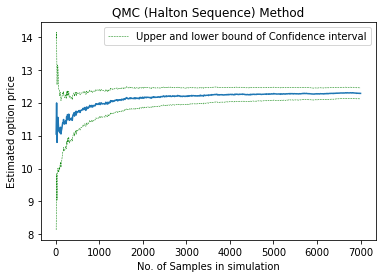

In [36]:
#Ploting quasi-Monte Carlo method using Halton sequence

plt.plot(x_axis1, halton_price_esitmates)
plt.plot(x_axis1, halton_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, halton_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("QMC (Halton Sequence) Method")
plt.legend()
plt.show()

## Comparison and Conclusion

In [38]:
tol = 0.5
sobol_threshold = threshold_finder(sobol_CIs, tol)
halton_threshold = threshold_finder(halton_CIs, tol)
mc_threshold = threshold_finder(ordinaryMC_CIs, tol)

print("Largest sample size by which ordinary MC can reach CI shorter than 0.5 dollor is:", str(mc_threshold*10))
print("Largest sample size by which QMC using Sobol sequence can reach CI shorter than 0.5 dollor is:", str(sobol_threshold*10))
print("Largest sample size by which QMC using Halton sequence can reach CI shorter than 0.5 dollor is:", str(halton_threshold*10))

Largest sample size by which ordinary MC can reach CI shorter than 0.5 dollor is: 3090
Largest sample size by which QMC using Sobol sequence can reach CI shorter than 0.5 dollor is: 50
Largest sample size by which QMC using Halton sequence can reach CI shorter than 0.5 dollor is: 3000


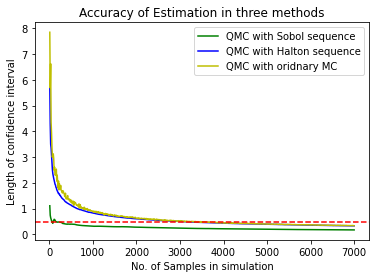

In [39]:
sobol_CI_lengths = CI_length_calc(sobol_CIs)
halton_CI_lengths = CI_length_calc(halton_CIs)
ordinary_CI_lengths = CI_length_calc(ordinaryMC_CIs)

plt.plot(x_axis1, sobol_CI_lengths, 'g', label="QMC with Sobol sequence")
plt.plot(x_axis1, halton_CI_lengths, 'b', label="QMC with Halton sequence")
plt.plot(x_axis1, ordinary_CI_lengths, 'y', label="QMC with oridnary MC")

plt.axhline(tol, ls='--', c='r')
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Length of confidence interval")
plt.title("Accuracy of Estimation in three methods")
plt.legend()
plt.show()

| Simulation Method | Estimated Price at largest sample | Convergence sample size | CI length at largest sample |
|-------------------|-----------------------------------|-------------------------|-----------------------------|
| Ordinary MC       |              \$12.39              |           3090          |             0.34            |
| Sobol sequence    |              \$11.72              |           50            |             0.17            |
| Halton Sequence   |              \$12.28              |           3000          |             0.33            |